<a href="https://colab.research.google.com/github/tanumeena28/ML-Assignment/blob/main/ML_ASSI7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columns found: ['Day', 'Outlook', 'Temperature', 'Humidity', 'Wind', 'PlayCricket']

Sample Data:
   Day   Outlook Temperature Humidity    Wind PlayCricket
0  D1     Sunny         Hot     High    Weak          No
1  D2     Sunny         Hot     High  Strong          No
2  D3  Overcast         Hot     High    Weak         Yes
3  D4      Rain        Mild     High    Weak         Yes
4  D5      Rain        Cool   Normal    Weak         Yes

Detected Target Column: PlayCricket
Fold 1: ID3=0.333, C4.5=0.333
Fold 2: ID3=0.333, C4.5=0.667
Fold 3: ID3=0.667, C4.5=0.667
Fold 4: ID3=0.333, C4.5=0.333
Fold 5: ID3=0.000, C4.5=0.000


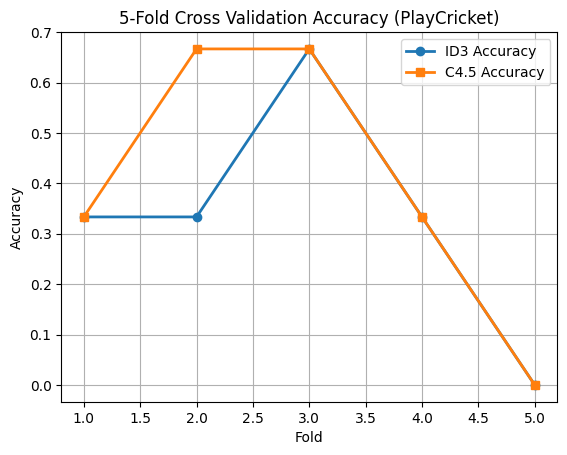

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ===== STEP 1: Load Data =====
data = pd.read_csv("playCricket.csv")

print("Columns found:", data.columns.tolist())
print("\nSample Data:\n", data.head())

# Automatically detect target column (last column)
target_col = data.columns[-1]
print(f"\nDetected Target Column: {target_col}")

# ===== STEP 2: Encode categorical columns =====
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category').cat.codes

# Separate features and target
X = data.drop(columns=[target_col])
y = data[target_col]

# ===== STEP 3: Helper Functions =====
def entropy(y):
    """Calculate entropy of a label array"""
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-9))

def info_gain(X_col, y):
    """Information Gain for ID3"""
    total_entropy = entropy(y)
    values, counts = np.unique(X_col, return_counts=True)
    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) * entropy(y[X_col == values[i]]) for i in range(len(values))])
    return total_entropy - weighted_entropy

def best_split(X, y, use_c45=False):
    """Select best feature by Information Gain or Gain Ratio"""
    best_feat, best_gain = None, -1
    for col in X.columns:
        gain = info_gain(X[col], y)
        if use_c45:
            split_info = entropy(X[col])
            gain = gain / split_info if split_info != 0 else 0
        if gain > best_gain:
            best_gain, best_feat = gain, col
    return best_feat

def build_tree(X, y, use_c45=False):
    """Recursively build Decision Tree"""
    if len(np.unique(y)) == 1:
        return np.unique(y)[0]
    if X.shape[1] == 0:
        return np.bincount(y).argmax()

    best_feat = best_split(X, y, use_c45)
    tree = {best_feat: {}}

    for val in np.unique(X[best_feat]):
        sub_X = X[X[best_feat] == val].drop(columns=[best_feat])
        sub_y = y[X[best_feat] == val]
        subtree = build_tree(sub_X, sub_y, use_c45)
        tree[best_feat][val] = subtree
    return tree

def predict_one(tree, x):
    """Predict a single sample"""
    for node in tree.keys():
        value = x[node]
        if value in tree[node]:
            result = tree[node][value]
            if isinstance(result, dict):
                return predict_one(result, x)
            else:
                return result
        else:
            return 0
    return 0

def predict(tree, X):
    """Predict for all samples"""
    return [predict_one(tree, X.iloc[i]) for i in range(X.shape[0])]

# ===== STEP 4: 5-Fold Cross Validation =====
kf = KFold(n_splits=5, shuffle=True, random_state=42)
id3_acc, c45_acc = [], []

fold = 1
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    tree_id3 = build_tree(X_train, y_train, use_c45=False)
    tree_c45 = build_tree(X_train, y_train, use_c45=True)

    y_pred_id3 = predict(tree_id3, X_test)
    y_pred_c45 = predict(tree_c45, X_test)

    id3_acc.append(accuracy_score(y_test, y_pred_id3))
    c45_acc.append(accuracy_score(y_test, y_pred_c45))

    print(f"Fold {fold}: ID3={id3_acc[-1]:.3f}, C4.5={c45_acc[-1]:.3f}")
    fold += 1

# ===== STEP 5: Plot Accuracy =====
plt.plot(range(1, 6), id3_acc, marker='o', label='ID3 Accuracy', linewidth=2)
plt.plot(range(1, 6), c45_acc, marker='s', label='C4.5 Accuracy', linewidth=2)
plt.title("5-Fold Cross Validation Accuracy (PlayCricket)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


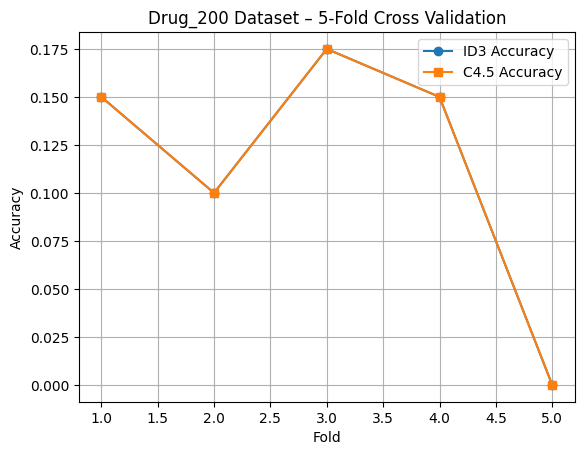

Average ID3 Accuracy: 0.11499999999999999
Average C4.5 Accuracy: 0.11499999999999999


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# ===== Load and Encode Dataset =====
data = pd.read_csv("drug_200.csv")

# Automatically take last column as target
target = data.columns[-1]
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category').cat.codes

X = data.drop(columns=[target])
y = data[target]

# ===== Helper Functions =====
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-9))

def info_gain(X_col, y):
    total_entropy = entropy(y)
    values, counts = np.unique(X_col, return_counts=True)
    weighted_entropy = np.sum([(counts[i]/np.sum(counts)) * entropy(y[X_col == values[i]]) for i in range(len(values))])
    return total_entropy - weighted_entropy

def best_split(X, y, use_c45=False):
    best_feat, best_gain = None, -1
    for col in X.columns:
        gain = info_gain(X[col], y)
        if use_c45:
            split_info = entropy(X[col])
            gain = gain / split_info if split_info != 0 else 0
        if gain > best_gain:
            best_gain, best_feat = gain, col
    return best_feat

def build_tree(X, y, use_c45=False):
    if len(np.unique(y)) == 1:
        return np.unique(y)[0]
    if X.shape[1] == 0:
        return np.bincount(y).argmax()
    best_feat = best_split(X, y, use_c45)
    tree = {best_feat: {}}
    for val in np.unique(X[best_feat]):
        sub_X = X[X[best_feat] == val].drop(columns=[best_feat])
        sub_y = y[X[best_feat] == val]
        subtree = build_tree(sub_X, sub_y, use_c45)
        tree[best_feat][val] = subtree
    return tree

def predict_one(tree, x):
    """Predict a single sample recursively"""
    for node in tree.keys():
        value = x[node]
        if value in tree[node]:
            result = tree[node][value]
            if isinstance(result, dict):
                return predict_one(result, x)
            else:
                return result
        else:
            # if unseen value, return most frequent class (0 as default)
            return 0
    return 0

def predict(tree, X):
    return [predict_one(tree, X.iloc[i]) for i in range(X.shape[0])]

# ===== 5-Fold Cross Validation =====
kf = KFold(n_splits=5, shuffle=True, random_state=42)
id3_acc, c45_acc = [], []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    tree_id3 = build_tree(X_train, y_train, use_c45=False)
    tree_c45 = build_tree(X_train, y_train, use_c45=True)

    y_pred_id3 = predict(tree_id3, X_test)
    y_pred_c45 = predict(tree_c45, X_test)

    id3_acc.append(accuracy_score(y_test, y_pred_id3))
    c45_acc.append(accuracy_score(y_test, y_pred_c45))

# ===== Accuracy Graph =====
plt.plot(range(1,6), id3_acc, 'o-', label="ID3 Accuracy")
plt.plot(range(1,6), c45_acc, 's-', label="C4.5 Accuracy")
plt.title("Drug_200 Dataset – 5-Fold Cross Validation")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print("Average ID3 Accuracy:", np.mean(id3_acc))
print("Average C4.5 Accuracy:", np.mean(c45_acc))


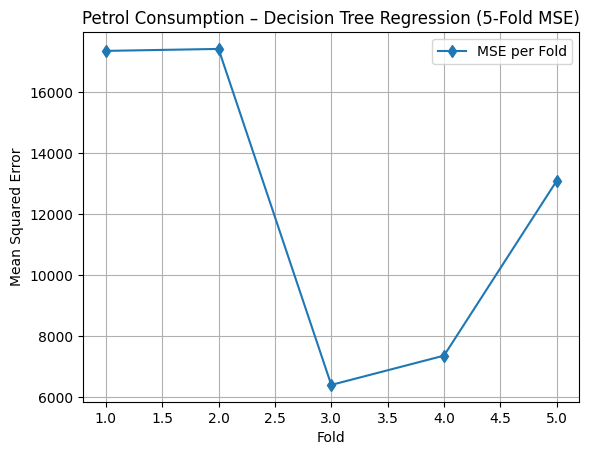

Average MSE: 12317.497777777777


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# ===== Load Dataset =====
data = pd.read_csv("petrol_consumption.csv")
target = data.columns[-1]
X = data.drop(columns=[target])
y = data[target]

# ===== 5-Fold Cross-Validation =====
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

for tr, te in kf.split(X):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = y.iloc[tr], y.iloc[te]

    model = DecisionTreeRegressor(random_state=42)
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    mse_scores.append(mean_squared_error(yte, y_pred))

# ===== Graph =====
plt.plot(range(1,6), mse_scores, 'd-', label="MSE per Fold")
plt.title("Petrol Consumption – Decision Tree Regression (5-Fold MSE)")
plt.xlabel("Fold"); plt.ylabel("Mean Squared Error")
plt.legend(); plt.grid(True); plt.show()

print("Average MSE:", np.mean(mse_scores))
